In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64
seed=3

In [3]:
holdOutSamples=['HV1','P22','P14','P27']

In [4]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)

imgsC_all=None
imgsP_all=None
imgNames_all=None
proteinNames=None
pID_all=None
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID in holdOutSamples:
                print('hold out: '+pID)
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)

            imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
            proteinNames_curr=np.array([])
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))
            
            if pID_all is None:
                pID_all=np.repeat(pID,img.shape[0])
                imgsC_all=img[allIdx_all,[0]]
                imgNames_all=imgNames[allIdx_all]
                proteinNames=proteinNames_curr
                imgsP_all=imgP
            else:
                pID_all=np.concatenate((pID_all,np.repeat(pID,img.shape[0])))
                imgsC_all=np.concatenate((imgsC_all,img[allIdx_all,[0]]),axis=0)
                imgNames_all=np.concatenate((imgNames_all,imgNames[allIdx_all]))
                proteinNames=np.concatenate((proteinNames,proteinNames_curr))
                imgsP_all=np.concatenate((imgsP_all,imgP),axis=0)
imgsC_all=imgsC_all.reshape(imgsC_all.shape[0],1,imgsC_all.shape[1],imgsC_all.shape[2])

controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15


In [5]:
imgsC_val=None
imgsP_val=None
imgNames_val=None
proteinNames_val=None
pID_val=None
imgsP_val_all=None
imgsP_val_all_names=None
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID not in holdOutSamples:
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)

            imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
            imgP_all=np.zeros((img.shape[0],3,img.shape[2],img.shape[3]))
            proteinNames_val_curr=np.array([])
            imgsP_val_all_names_curr=None
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                proteinNames_val_curr=np.concatenate((proteinNames_val_curr,np.repeat(stain_list[s],s_end-s_start)))
                imgP_all[s_start:s_end,:img.shape[1]-1]=img[allIdx_all[s_start:s_end],1:].reshape(s_end-s_start,img.shape[1]-1,img.shape[2],img.shape[3])
                if imgsP_val_all_names_curr is None:
                    imgsP_val_all_names_curr=np.tile(stain_list[1:],(s_end-s_start,1))
                else:
                    imgsP_val_all_names_curr=np.concatenate((imgsP_val_all_names_curr,np.tile(stain_list[1:],(s_end-s_start,1))),axis=0)
            if imgsP_val_all_names_curr.shape[1]==2:
                imgsP_val_all_names_curr=np.hstack((imgsP_val_all_names_curr,np.repeat('None',imgsP_val_all_names_curr.shape[0]).reshape(-1,1)))
            if pID_val is None:
                pID_val=np.repeat(pID,img.shape[0])
                imgsC_val=img[allIdx_all,[0]]
                imgNames_val=imgNames[allIdx_all]
                proteinNames_val=proteinNames_val_curr
                imgsP_val=imgP
                imgsP_val_all=imgP_all
                imgsP_val_all_names=imgsP_val_all_names_curr
            else:
                pID_val=np.concatenate((pID_val,np.repeat(pID,img.shape[0])))
                imgsC_val=np.concatenate((imgsC_val,img[allIdx_all,[0]]),axis=0)
                imgNames_val=np.concatenate((imgNames_val,imgNames[allIdx_all]))
                proteinNames_val=np.concatenate((proteinNames_val,proteinNames_val_curr))
                imgsP_val=np.concatenate((imgsP_val,imgP),axis=0)
                imgsP_val_all=np.concatenate((imgsP_val_all,imgP_all),axis=0)
                imgsP_val_all_names=np.concatenate((imgsP_val_all_names,imgsP_val_all_names_curr),axis=0)
imgsC_val=imgsC_val.reshape(imgsC_val.shape[0],1,imgsC_val.shape[1],imgsC_val.shape[2])

controls
dapi_gh2ax_lamin
HV1
dapi_cd8_cd4
HV1
headneck
dapi_gh2ax_lamin_cd3
P14
dapi_cd16_cd4_cd8
P14
meningioma
dapi_gh2ax_lamin_cd3
P27
dapi_cd16_cd4_cd8
P27
glioma
dapi_gh2ax_lamin_cd3
P22
dapi_cd16_cd4_cd8
P22


In [6]:
nProt=np.unique(proteinNames).size
pnames,revIdx,pCounts=np.unique(proteinNames,return_inverse=True,return_counts=True)
plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

In [7]:
nProt_val=np.unique(proteinNames_val).size
pnames_val,revIdx_val,pCounts_val=np.unique(proteinNames_val,return_inverse=True,return_counts=True)
plabels_val=torch.tensor(np.arange(pnames_val.size)[revIdx_val]).long()

In [8]:
nProt==nProt_val

True

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [10]:
#VAE settings
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001





In [11]:
trainIdx=np.arange(imgsC_all.shape[0])
printFreq=1
valIdx=np.arange(imgsC_val.shape[0])
def train(epoch):
    t = time.time()
    modelcnn_dna.train()
    modelcnn_protein.train()

    loss_x_train_all_dna=0
    loss_x_trainShared_all_dna=0
    loss_x_train_all_protein=0
    loss_x_trainShared_all_protein=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        traintarget_protein=torch.tensor(imgsP_all[trainIdx_i]).cuda().float()
        trainIdx_i=torch.tensor(trainIdx_i)
        traintarget_dna=torch.tensor(imgsC_all[trainIdx_i]).cuda().float()
        trainInput_ID=plabels[trainIdx_i].cuda()
        trainInput_shared=latent_shared_dec(trainIdx_i).cuda().float()
        trainInput_dna=latent_dna_dec(trainIdx_i).cuda().float()
        trainInput_protein=latent_protein_dec(trainIdx_i).cuda().float()

        optimizer_dna.zero_grad()
        optimizer_protein.zero_grad()

        reconShared_dna,recon_dna= modelcnn_dna(traintarget_dna,trainInput_ID)
        reconShared_protein,recon_protein= modelcnn_protein(traintarget_protein,trainInput_ID)
        
        loss_x_train_protein=loss_x(recon_protein, trainInput_protein)
        loss_xShared_train_protein=loss_x(reconShared_protein,trainInput_shared)
        loss_x_train_dna=loss_x(recon_dna, trainInput_dna)
        loss_xShared_train_dna=loss_x(reconShared_dna,trainInput_shared)
        
        loss=loss_x_train_protein+loss_xShared_train_protein+loss_x_train_dna+loss_xShared_train_dna
        
        loss_x_train_all_dna+=loss_x_train_dna.item()
        loss_x_trainShared_all_dna+=loss_xShared_train_dna.item()
        loss_x_train_all_protein+=loss_x_train_protein.item()
        loss_x_trainShared_all_protein+=loss_xShared_train_protein.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizer_dna.step()
        optimizer_protein.step()


    loss_x_train_all_dna=loss_x_train_all_dna/ntrainBatches
    loss_x_trainShared_all_dna=loss_x_trainShared_all_dna/ntrainBatches
    loss_x_train_all_protein=loss_x_train_all_protein/ntrainBatches
    loss_x_trainShared_all_protein=loss_x_trainShared_all_protein/ntrainBatches
    loss_all=loss_all/ntrainBatches

    with torch.no_grad():
        modelcnn_dna.eval()
        modelcnn_protein.eval()



        loss_val_all=0
        loss_x_val_all_dna=0
        loss_x_val_all_protein=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_protein=torch.tensor(imgsP_val[valIdx_i]).cuda().float()
            valtarget_dna=torch.tensor(imgsC_val[valIdx_i]).cuda().float()
            valInput_ID=plabels_val[valIdx_i].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)
            reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_protein,valInput_ID)
            
            recon_dna= modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
            recon_protein= modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))

            loss_x_val_protein=loss_imgRecon(recon_protein, valtarget_protein)
            loss_x_val_dna=loss_imgRecon(recon_dna, valtarget_dna)

            loss=loss_x_val_protein+loss_x_val_dna

            loss_x_val_all_dna+=loss_x_val_dna.item()
            loss_x_val_all_protein+=loss_x_val_protein.item()
            loss_val_all+=loss.item()

        loss_x_val_all_dna=loss_x_val_all_dna/nvalBatches
        loss_x_val_all_protein=loss_x_val_all_protein/nvalBatches
        loss_val_all=loss_val_all/nvalBatches



    if epoch%printFreq==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_x_train_dna: {:.4f}'.format(loss_x_train_all_dna),
              'loss_x_train_protein: {:.4f}'.format(loss_x_train_all_protein),
              'loss_xShared_train_dna: {:.4f}'.format(loss_x_trainShared_all_dna),
              'loss_xShared_train_protein: {:.4f}'.format(loss_x_trainShared_all_protein),
              'loss_x_val_dna: {:.4f}'.format(loss_x_val_all_dna),
              'loss_x_val_protein: {:.4f}'.format(loss_x_val_all_protein),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_x_train_all_dna,loss_x_train_all_protein,loss_x_trainShared_all_dna,loss_x_trainShared_all_protein,loss_val_all,loss_x_val_all_dna,loss_x_val_all_protein
    

In [12]:
match_weight=1
sharedWeight=1
name_train='splitChannels_conditional_lord_withNoise_bce_noSharedRecon_all'
modelname_train='cnn_vae_pbmc_lord'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
    os.mkdir(os.path.join(logsavepath_train,'dna'))
    os.mkdir(os.path.join(logsavepath_train,'protein'))
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
    os.mkdir(os.path.join(modelsavepath_train,'dna'))
    os.mkdir(os.path.join(modelsavepath_train,'protein'))
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)
    os.mkdir(os.path.join(plotsavepath_train,'dna'))
    os.mkdir(os.path.join(plotsavepath_train,'protein'))


loadEpoch='3399'


1024
200
Epoch: 0000 loss_train: 10.7852 loss_x_train_dna: 2.1309 loss_x_train_protein: 1.5112 loss_xShared_train_dna: 3.4196 loss_xShared_train_protein: 3.7234 loss_x_val_dna: 0.2741 loss_x_val_protein: 0.1715 time: 14.9537s
Epoch: 0001 loss_train: 9.7996 loss_x_train_dna: 1.8494 loss_x_train_protein: 1.3934 loss_xShared_train_dna: 3.0015 loss_xShared_train_protein: 3.5553 loss_x_val_dna: 0.2652 loss_x_val_protein: 0.1710 time: 13.2341s
Epoch: 0002 loss_train: 9.4053 loss_x_train_dna: 1.7638 loss_x_train_protein: 1.3499 loss_xShared_train_dna: 2.8912 loss_xShared_train_protein: 3.4005 loss_x_val_dna: 0.2638 loss_x_val_protein: 0.1678 time: 13.0932s
Epoch: 0003 loss_train: 9.1617 loss_x_train_dna: 1.7154 loss_x_train_protein: 1.3280 loss_xShared_train_dna: 2.8342 loss_xShared_train_protein: 3.2840 loss_x_val_dna: 0.2623 loss_x_val_protein: 0.1682 time: 12.8010s
Epoch: 0004 loss_train: 9.0081 loss_x_train_dna: 1.6860 loss_x_train_protein: 1.3167 loss_xShared_train_dna: 2.7902 loss_xShar

KeyboardInterrupt: 

Epoch: 0300 loss_train: 8.7153 loss_x_train_dna: 1.3258 loss_x_train_protein: 1.0755 loss_xShared_train_dna: 2.9306 loss_xShared_train_protein: 3.3833 loss_x_val_dna: 0.2591 loss_x_val_protein: 0.1618 loss_xShared_val_dna: 0.2596 loss_xShared_val_protein: 0.1624 time: 27.2945s
Epoch: 0301 loss_train: 8.6992 loss_x_train_dna: 1.3253 loss_x_train_protein: 1.0746 loss_xShared_train_dna: 2.9276 loss_xShared_train_protein: 3.3716 loss_x_val_dna: 0.2591 loss_x_val_protein: 0.1622 loss_xShared_val_dna: 0.2596 loss_xShared_val_protein: 0.1627 time: 28.1312s
Epoch: 0302 loss_train: 8.6847 loss_x_train_dna: 1.3243 loss_x_train_protein: 1.0733 loss_xShared_train_dna: 2.9260 loss_xShared_train_protein: 3.3610 loss_x_val_dna: 0.2592 loss_x_val_protein: 0.1619 loss_xShared_val_dna: 0.2597 loss_xShared_val_protein: 0.1624 time: 27.9136s
Epoch: 0303 loss_train: 8.6875 loss_x_train_dna: 1.3240 loss_x_train_protein: 1.0746 loss_xShared_train_dna: 2.9250 loss_xShared_train_protein: 3.3639 loss_x_val_dna:

Epoch: 0330 loss_train: 8.5829 loss_x_train_dna: 1.3115 loss_x_train_protein: 1.0619 loss_xShared_train_dna: 2.9014 loss_xShared_train_protein: 3.3080 loss_x_val_dna: 0.2590 loss_x_val_protein: 0.1620 loss_xShared_val_dna: 0.2596 loss_xShared_val_protein: 0.1624 time: 27.3699s
Epoch: 0331 loss_train: 8.5586 loss_x_train_dna: 1.3110 loss_x_train_protein: 1.0586 loss_xShared_train_dna: 2.8955 loss_xShared_train_protein: 3.2935 loss_x_val_dna: 0.2591 loss_x_val_protein: 0.1621 loss_xShared_val_dna: 0.2596 loss_xShared_val_protein: 0.1625 time: 23.9201s
Epoch: 0332 loss_train: 8.5449 loss_x_train_dna: 1.3099 loss_x_train_protein: 1.0574 loss_xShared_train_dna: 2.8935 loss_xShared_train_protein: 3.2840 loss_x_val_dna: 0.2591 loss_x_val_protein: 0.1623 loss_xShared_val_dna: 0.2597 loss_xShared_val_protein: 0.1627 time: 25.7693s
Epoch: 0333 loss_train: 8.5217 loss_x_train_dna: 1.3090 loss_x_train_protein: 1.0540 loss_xShared_train_dna: 2.8894 loss_xShared_train_protein: 3.2693 loss_x_val_dna:

Epoch: 0360 loss_train: 8.4421 loss_x_train_dna: 1.2961 loss_x_train_protein: 1.0480 loss_xShared_train_dna: 2.8653 loss_xShared_train_protein: 3.2327 loss_x_val_dna: 0.2586 loss_x_val_protein: 0.1622 loss_xShared_val_dna: 0.2590 loss_xShared_val_protein: 0.1626 time: 20.2279s
Epoch: 0361 loss_train: 8.4467 loss_x_train_dna: 1.2960 loss_x_train_protein: 1.0471 loss_xShared_train_dna: 2.8686 loss_xShared_train_protein: 3.2350 loss_x_val_dna: 0.2586 loss_x_val_protein: 0.1621 loss_xShared_val_dna: 0.2590 loss_xShared_val_protein: 0.1626 time: 21.1285s
Epoch: 0362 loss_train: 8.4286 loss_x_train_dna: 1.2960 loss_x_train_protein: 1.0439 loss_xShared_train_dna: 2.8637 loss_xShared_train_protein: 3.2250 loss_x_val_dna: 0.2586 loss_x_val_protein: 0.1620 loss_xShared_val_dna: 0.2590 loss_xShared_val_protein: 0.1624 time: 22.1899s
Epoch: 0363 loss_train: 8.4284 loss_x_train_dna: 1.2945 loss_x_train_protein: 1.0437 loss_xShared_train_dna: 2.8608 loss_xShared_train_protein: 3.2294 loss_x_val_dna:

Epoch: 0390 loss_train: 8.3483 loss_x_train_dna: 1.2841 loss_x_train_protein: 1.0382 loss_xShared_train_dna: 2.8385 loss_xShared_train_protein: 3.1875 loss_x_val_dna: 0.2587 loss_x_val_protein: 0.1616 loss_xShared_val_dna: 0.2591 loss_xShared_val_protein: 0.1622 time: 24.1636s
Epoch: 0391 loss_train: 8.3678 loss_x_train_dna: 1.2815 loss_x_train_protein: 1.0408 loss_xShared_train_dna: 2.8367 loss_xShared_train_protein: 3.2088 loss_x_val_dna: 0.2587 loss_x_val_protein: 0.1618 loss_xShared_val_dna: 0.2590 loss_xShared_val_protein: 0.1623 time: 20.1016s
Epoch: 0392 loss_train: 8.3800 loss_x_train_dna: 1.2805 loss_x_train_protein: 1.0420 loss_xShared_train_dna: 2.8320 loss_xShared_train_protein: 3.2256 loss_x_val_dna: 0.2587 loss_x_val_protein: 0.1617 loss_xShared_val_dna: 0.2591 loss_xShared_val_protein: 0.1623 time: 19.7072s
Epoch: 0393 loss_train: 8.3976 loss_x_train_dna: 1.2788 loss_x_train_protein: 1.0435 loss_xShared_train_dna: 2.8298 loss_xShared_train_protein: 3.2455 loss_x_val_dna:

Epoch: 0426 loss_train: 8.2910 loss_x_train_dna: 1.2751 loss_x_train_protein: 1.0352 loss_xShared_train_dna: 2.8199 loss_xShared_train_protein: 3.1608 loss_x_val_dna: 0.2586 loss_x_val_protein: 0.1624 loss_xShared_val_dna: 0.2591 loss_xShared_val_protein: 0.1628 time: 20.7598s
Epoch: 0427 loss_train: 8.2891 loss_x_train_dna: 1.2750 loss_x_train_protein: 1.0338 loss_xShared_train_dna: 2.8181 loss_xShared_train_protein: 3.1622 loss_x_val_dna: 0.2587 loss_x_val_protein: 0.1624 loss_xShared_val_dna: 0.2591 loss_xShared_val_protein: 0.1629 time: 22.6843s
Epoch: 0428 loss_train: 8.2781 loss_x_train_dna: 1.2747 loss_x_train_protein: 1.0328 loss_xShared_train_dna: 2.8139 loss_xShared_train_protein: 3.1567 loss_x_val_dna: 0.2587 loss_x_val_protein: 0.1624 loss_xShared_val_dna: 0.2592 loss_xShared_val_protein: 0.1630 time: 23.5732s
Epoch: 0429 loss_train: 8.2804 loss_x_train_dna: 1.2732 loss_x_train_protein: 1.0333 loss_xShared_train_dna: 2.8159 loss_xShared_train_protein: 3.1580 loss_x_val_dna:

Epoch: 0456 loss_train: 8.1995 loss_x_train_dna: 1.2574 loss_x_train_protein: 1.0275 loss_xShared_train_dna: 2.7768 loss_xShared_train_protein: 3.1378 loss_x_val_dna: 0.2596 loss_x_val_protein: 0.1622 loss_xShared_val_dna: 0.2603 loss_xShared_val_protein: 0.1628 time: 18.5261s
Epoch: 0457 loss_train: 8.1872 loss_x_train_dna: 1.2571 loss_x_train_protein: 1.0259 loss_xShared_train_dna: 2.7780 loss_xShared_train_protein: 3.1261 loss_x_val_dna: 0.2595 loss_x_val_protein: 0.1624 loss_xShared_val_dna: 0.2601 loss_xShared_val_protein: 0.1628 time: 19.7512s
Epoch: 0458 loss_train: 8.1857 loss_x_train_dna: 1.2566 loss_x_train_protein: 1.0271 loss_xShared_train_dna: 2.7770 loss_xShared_train_protein: 3.1249 loss_x_val_dna: 0.2594 loss_x_val_protein: 0.1625 loss_xShared_val_dna: 0.2600 loss_xShared_val_protein: 0.1629 time: 20.7963s
Epoch: 0459 loss_train: 8.1873 loss_x_train_dna: 1.2565 loss_x_train_protein: 1.0270 loss_xShared_train_dna: 2.7782 loss_xShared_train_protein: 3.1256 loss_x_val_dna:

Epoch: 0486 loss_train: 8.1258 loss_x_train_dna: 1.2508 loss_x_train_protein: 1.0191 loss_xShared_train_dna: 2.7716 loss_xShared_train_protein: 3.0842 loss_x_val_dna: 0.2593 loss_x_val_protein: 0.1625 loss_xShared_val_dna: 0.2598 loss_xShared_val_protein: 0.1629 time: 20.4419s
Epoch: 0487 loss_train: 8.1328 loss_x_train_dna: 1.2501 loss_x_train_protein: 1.0198 loss_xShared_train_dna: 2.7691 loss_xShared_train_protein: 3.0937 loss_x_val_dna: 0.2592 loss_x_val_protein: 0.1624 loss_xShared_val_dna: 0.2598 loss_xShared_val_protein: 0.1628 time: 18.8478s
Epoch: 0488 loss_train: 8.1277 loss_x_train_dna: 1.2501 loss_x_train_protein: 1.0192 loss_xShared_train_dna: 2.7664 loss_xShared_train_protein: 3.0920 loss_x_val_dna: 0.2592 loss_x_val_protein: 0.1625 loss_xShared_val_dna: 0.2597 loss_xShared_val_protein: 0.1629 time: 21.6204s
Epoch: 0489 loss_train: 8.1097 loss_x_train_dna: 1.2487 loss_x_train_protein: 1.0189 loss_xShared_train_dna: 2.7622 loss_xShared_train_protein: 3.0799 loss_x_val_dna:

Epoch: 0516 loss_train: 8.0652 loss_x_train_dna: 1.2406 loss_x_train_protein: 1.0203 loss_xShared_train_dna: 2.7451 loss_xShared_train_protein: 3.0592 loss_x_val_dna: 0.2590 loss_x_val_protein: 0.1626 loss_xShared_val_dna: 0.2595 loss_xShared_val_protein: 0.1631 time: 14.0372s
Epoch: 0517 loss_train: 8.0852 loss_x_train_dna: 1.2402 loss_x_train_protein: 1.0216 loss_xShared_train_dna: 2.7443 loss_xShared_train_protein: 3.0792 loss_x_val_dna: 0.2589 loss_x_val_protein: 0.1627 loss_xShared_val_dna: 0.2594 loss_xShared_val_protein: 0.1632 time: 14.1419s
Epoch: 0518 loss_train: 8.0682 loss_x_train_dna: 1.2389 loss_x_train_protein: 1.0186 loss_xShared_train_dna: 2.7397 loss_xShared_train_protein: 3.0710 loss_x_val_dna: 0.2589 loss_x_val_protein: 0.1623 loss_xShared_val_dna: 0.2594 loss_xShared_val_protein: 0.1628 time: 14.2702s
Epoch: 0519 loss_train: 8.0745 loss_x_train_dna: 1.2395 loss_x_train_protein: 1.0194 loss_xShared_train_dna: 2.7387 loss_xShared_train_protein: 3.0769 loss_x_val_dna:

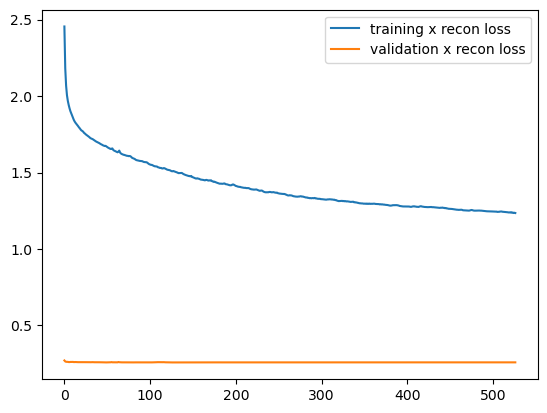

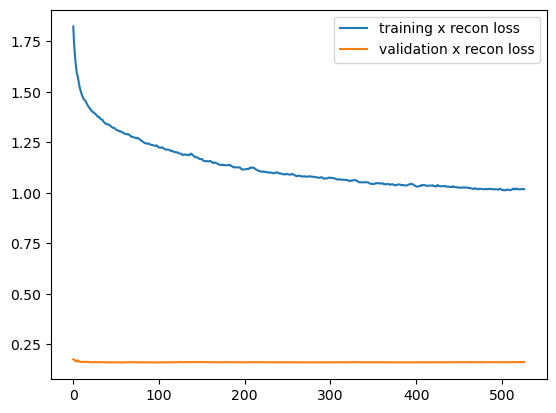

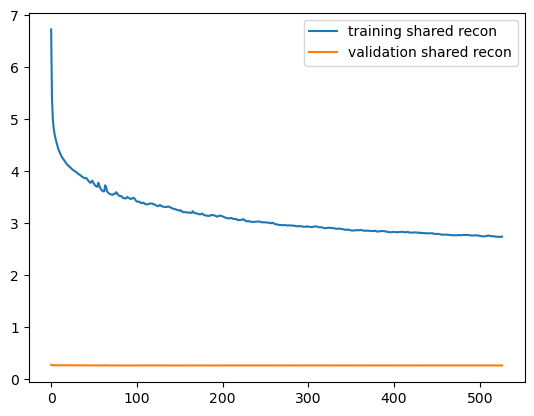

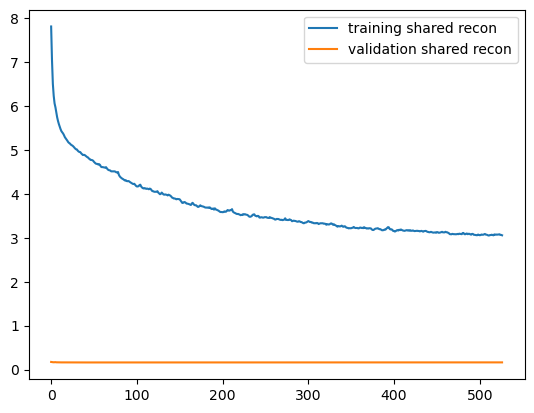

In [13]:

logsavepath_p_dna=os.path.join(logsavepath_train,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_train,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_train,'dna')
if not os.path.exists(logsavepath_p_dna):
    os.mkdir(logsavepath_p_dna)
if not os.path.exists(modelsavepath_p_dna):
    os.mkdir(modelsavepath_p_dna)
if not os.path.exists(plotsavepath_p_dna):
    os.mkdir(plotsavepath_p_dna)

logsavepath_p_protein=os.path.join(logsavepath_train,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_train,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_train,'protein')
if not os.path.exists(logsavepath_p_protein):
    os.mkdir(logsavepath_p_protein)
if not os.path.exists(modelsavepath_p_protein):
    os.mkdir(modelsavepath_p_protein)
if not os.path.exists(plotsavepath_p_protein):
    os.mkdir(plotsavepath_p_protein)

#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(proteinNames.size)
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*proteinNames.size)]
testIdx_all=allIdx_all[int(pctVal*proteinNames.size):(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size))]
trainIdx_all=allIdx_all[(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size)):]



for currLatentSize in sharedSizes:
    for dSpecificSize,dfilterSize in dSpecific_filter:
        latent_curr=None

        print(currLatentSize)
        print(dSpecificSize)
        dna_cShared=hidden5-dfilterSize
        p_cShared=dna_cShared

        loss_kl=optimizer.optimizer_kl
        loss_x=torch.nn.MSELoss()
        loss_imgRecon=torch.nn.BCEWithLogitsLoss()

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size,applySigmoid=False)
            modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size,applySigmoid=False)
        modelcnn_dna_dec.cuda().eval()
        modelcnn_protein_dec.cuda().eval()
        
        batchsize=328
        latent_shared_dec=torch.nn.Embedding(proteinNames.size,currLatentSize)
        
        latent_protein_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        latent_dna_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()

        
        if loadEpoch is not None:
            with open(os.path.join(modelsavepath_p_dna,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_dna_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'latentShared_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_shared_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_protein_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                pIDemb_dec.weight=pickle.load(output)
            
            with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
                stateDict_train_dna_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
                stateDict_train_protein_dec=pickle.load(output)

            modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
            modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
        latent_shared_dec.weight.requires_grad=False
        
        latent_protein_dec.weight.requires_grad=False
        latent_dna_dec.weight.requires_grad=False
        pIDemb_dec.weight.requires_grad=False



        train_loss=[np.inf]*(epochs)
        train_loss_x_dna=[np.inf]*(epochs)
        train_loss_xShared_dna=[np.inf]*(epochs)
        val_loss=[np.inf]*(epochs)
        val_loss_x_dna=[np.inf]*(epochs)

        train_loss_x_protein=[np.inf]*(epochs)
        train_loss_xShared_protein=[np.inf]*(epochs)
        val_loss_x_protein=[np.inf]*(epochs)

        t_ep=time.time()

        stateDict_train_dna={}
        stateDict_train_protein={}
        stateDict_train_dnaShared={}
        stateDict_train_proteinShared={}
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
            modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
        modelcnn_dna.cuda()
        modelcnn_protein.cuda()
        
        optimizer_dna = torch.optim.Adam(modelcnn_dna.parameters(), lr=lr, weight_decay=weight_decay)
        optimizer_protein = torch.optim.Adam(modelcnn_protein.parameters(), lr=lr, weight_decay=weight_decay)

                
        epCounts=0
        for ep in range(epochs):
            train_loss[ep],train_loss_x_dna[ep],train_loss_x_protein[ep],train_loss_xShared_dna[ep],train_loss_xShared_protein[ep],val_loss[ep],val_loss_x_dna[ep],val_loss_x_protein[ep]=train(ep)

            if ep>200 and (val_loss_x_dna[ep]>=val_loss_x_dna[ep-200] or val_loss_x_protein[ep]>=val_loss_x_protein[ep-200]):
                epCounts+=1
            else:
                epCounts=0

            if epCounts>100:
                break


            if ep%saveFreq == (saveFreq-1):
                stateDict_train_dna[ep]=modelcnn_dna.cpu().state_dict()
                stateDict_train_protein[ep]=modelcnn_protein.cpu().state_dict()

            modelcnn_dna.cuda()
            modelcnn_protein.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))

        with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(stateDict_train_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(stateDict_train_protein, output, pickle.HIGHEST_PROTOCOL)


        with open(os.path.join(logsavepath_p_dna,'train_loss_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'train_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(train_loss_x_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'train_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(train_loss_xShared_dna, output, pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(logsavepath_p_dna,'val_loss_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'val_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(val_loss_x_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'val_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(val_loss_xShared_dna, output, pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(logsavepath_p_protein,'train_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(train_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'val_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(val_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'train_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(train_loss_xShared_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'val_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
            pickle.dump(val_loss_xShared_protein, output, pickle.HIGHEST_PROTOCOL)

        totalepoch=np.argmin(np.array(val_loss_x_dna)+np.array(val_loss_x_protein))

        print('loss_val_p: {:.4f}'.format(val_loss_x_protein[totalepoch]),
              'loss_val_c: {:.4f}'.format(val_loss_x_dna[totalepoch]))


        plt.plot(np.arange(epochs),train_loss_x_dna)
        plt.plot(np.arange(epochs),val_loss_x_dna)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_dna,'loss_x_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'.jpg'))
        plt.show()


        plt.plot(np.arange(epochs),train_loss_x_protein)
        plt.plot(np.arange(epochs),val_loss_x_protein)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_protein,'loss_x_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'.jpg'))
        plt.show()

        plt.plot(np.arange(epochs),train_loss_xShared_dna)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training shared recon','validation shared recon'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_dna,'loss_xShared_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'.jpg'))
        plt.show()

        plt.plot(np.arange(epochs),train_loss_xShared_protein)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training shared recon','validation shared recon'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_protein,'loss_xShared_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'.jpg'))
        plt.show()










In [14]:
stateDict_train_dna[ep]=modelcnn_dna.cpu().state_dict()
stateDict_train_protein[ep]=modelcnn_protein.cpu().state_dict()

In [26]:
with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
    pickle.dump(stateDict_train_dna, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'wb') as output:
    pickle.dump(stateDict_train_protein, output, pickle.HIGHEST_PROTOCOL)



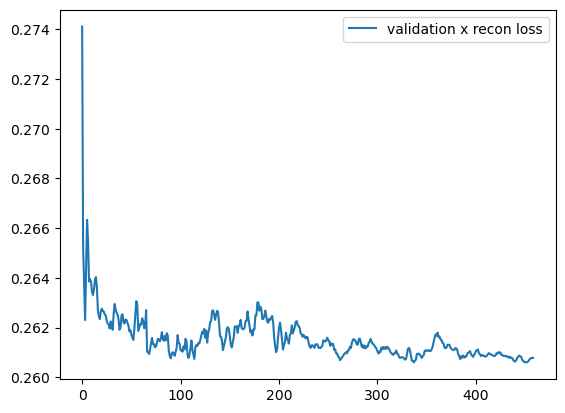

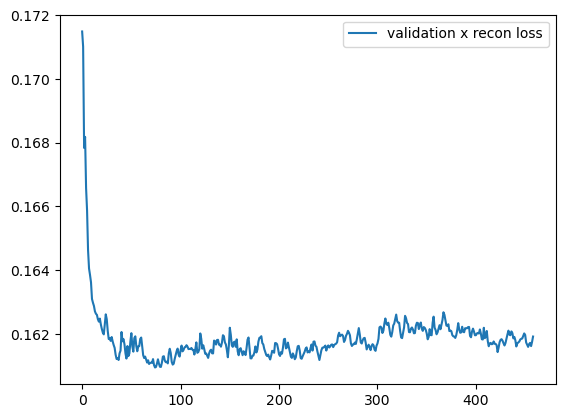

In [17]:
plt.plot(np.arange(epochs),val_loss_x_dna)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_dna,'loss_seed3_xval_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
plt.show()


plt.plot(np.arange(epochs),val_loss_x_protein)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath_p_protein,'loss_seed3_xval_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
plt.show()


In [21]:
logsavepath_p_dna=os.path.join(logsavepath_train,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_train,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_train,'dna')

logsavepath_p_protein=os.path.join(logsavepath_train,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_train,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_train,'protein')
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(proteinNames.size)
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*proteinNames.size)]
testIdx_all=allIdx_all[int(pctVal*proteinNames.size):(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size))]
trainIdx_all=allIdx_all[(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size)):]



for currLatentSize in sharedSizes:
    for dSpecificSize,dfilterSize in dSpecific_filter:
        latent_curr=None
#         if sIdx==0:
#             continue


        print(currLatentSize)
        print(dSpecificSize)
        dna_cShared=hidden5-dfilterSize
        p_cShared=dna_cShared

        loss_kl=optimizer.optimizer_kl
        loss_x=torch.nn.MSELoss()

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size,applySigmoid=False)
            modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size,applySigmoid=False)
        modelcnn_dna_dec.cuda().eval()
        modelcnn_protein_dec.cuda().eval()
        
        batchsize=328
        latent_shared_dec=torch.nn.Embedding(proteinNames.size,currLatentSize)
        
        latent_protein_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        latent_dna_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()

        
        if loadEpoch is not None:
            with open(os.path.join(modelsavepath_p_dna,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_dna_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'latentShared_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_shared_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                latent_protein_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)+'_'+str(loadEpoch)), 'rb') as output:
                pIDemb_dec.weight=pickle.load(output)
            
            with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
                stateDict_train_dna_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
                stateDict_train_protein_dec=pickle.load(output)

            modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
            modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
        latent_shared_dec.weight.requires_grad=False
        
        latent_protein_dec.weight.requires_grad=False
        latent_dna_dec.weight.requires_grad=False
        pIDemb_dec.weight.requires_grad=False


        stateDict_train_dna={}
        stateDict_train_protein={}
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
            modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
        modelcnn_dna.cuda()
        modelcnn_protein.cuda()

1024
200


In [25]:
with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(seed)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)


In [27]:
stateDict_train_dna.keys()

dict_keys([99, 199, 299, 399, 459])

In [28]:
modelcnn_dna.load_state_dict(stateDict_train_dna[99])
modelcnn_protein.load_state_dict(stateDict_train_protein[99])

<All keys matched successfully>

In [29]:
def percentileNorm(img_c):
#     intensity,intCounts=np.unique(img_c,return_counts=True)
#     modeint=intensity[np.argmax(intCounts)]
    modeint=np.percentile(img_c,80)
    img_c=img_c-modeint
    img_c[img_c<0]=0
    img_c=img_c/np.max(img_c)
    print(modeint)
    return img_c

def modeSub(img_c):
    intensity,intCounts=np.unique(img_c,return_counts=True)
    modeint=intensity[np.argmax(intCounts)]
#     modeint=np.percentile(img_c,75)
    img_c=img_c-modeint
    img_c[img_c<0]=0
    img_c=img_c/np.max(img_c)
    print(modeint)
    return img_c

def modeSub_torch(img_c):
    intensity,intCounts=torch.unique(img_c,return_counts=True)
    modeint=intensity[torch.argmax(intCounts)]
#     modeint=np.percentile(img_c,75)
    img_c=img_c-modeint
    img_c[img_c<0]=0
    img_c=img_c/torch.max(img_c)
#     print(modeint)
    return img_c

In [30]:
sigmoid=torch.nn.Sigmoid()

In [38]:
#get plotting index

plottingIdx=np.array([]).astype(int)

nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
for i in range(nvalBatches):
    valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]

    plottingIdx=np.concatenate((plottingIdx,valIdx_i[:10]))

        


In [39]:
plottingIdx

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,  328,
        329,  330,  331,  332,  333,  334,  335,  336,  337,  656,  657,
        658,  659,  660,  661,  662,  663,  664,  665,  984,  985,  986,
        987,  988,  989,  990,  991,  992,  993, 1312, 1313, 1314, 1315,
       1316, 1317, 1318, 1319, 1320, 1321, 1640, 1641, 1642, 1643, 1644,
       1645, 1646, 1647, 1648, 1649, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 2296, 2297, 2298, 2299, 2300, 2301, 2302,
       2303, 2304, 2305, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960,
       2961, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289])

In [40]:
pnames

array(['cd16', 'cd3', 'cd4', 'cd8', 'gh2ax', 'lamin'], dtype='<U32')

In [41]:
loss_x_noReduction=torch.nn.MSELoss(reduction='sum')

In [42]:
imgsC_val_allProt={}
imgsP_val_allProt={}
imgsP_val_allProt_input={}
imgNames_val_allProt={}
pID_val_allProt={}
conditions_val_allProt={}
proteinNames_val_allProt={}
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID not in holdOutSamples:
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)
                
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                proteinNames_val_curr=np.repeat(stain_list[s],s_end-s_start)
                imgP=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])

                for sother in range(1,len(stain_list)):
                    if sother==s:
                        continue
                    if stain_list[sother] not in imgsP_val_allProt.keys():
                        pID_val_allProt[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                        imgsC_val_allProt[stain_list[sother]]=img[allIdx_all[s_start:s_end],[0]].reshape(s_end-s_start,1,imgsC_val.shape[2],imgsC_val.shape[3])
                        imgNames_val_allProt[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                        imgsP_val_allProt[stain_list[sother]]=img[allIdx_all[s_start:s_end],[sother]].reshape(s_end-s_start,1,imgsC_val.shape[2],imgsC_val.shape[3])
                        conditions_val_allProt[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        proteinNames_val_allProt[stain_list[sother]]=proteinNames_val_curr
                        imgsP_val_allProt_input[stain_list[sother]]=imgP
                    else:
                        pID_val_allProt[stain_list[sother]]=np.concatenate((pID_val_allProt[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                        imgsC_val_allProt[stain_list[sother]]=np.concatenate((imgsC_val_allProt[stain_list[sother]],img[allIdx_all[s_start:s_end],[0]].reshape(s_end-s_start,1,imgsC_val.shape[2],imgsC_val.shape[3])),axis=0)
                        imgNames_val_allProt[stain_list[sother]]=np.concatenate((imgNames_val_allProt[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                        imgsP_val_allProt[stain_list[sother]]=np.concatenate((imgsP_val_allProt[stain_list[sother]],img[allIdx_all[s_start:s_end],[sother]].reshape(s_end-s_start,1,imgsC_val.shape[2],imgsC_val.shape[3])),axis=0)
                        conditions_val_allProt[stain_list[sother]]=np.concatenate((conditions_val_allProt[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                        proteinNames_val_allProt[stain_list[sother]]=np.concatenate((proteinNames_val_allProt[stain_list[sother]],proteinNames_val_curr))
                        imgsP_val_allProt_input[stain_list[sother]]=np.concatenate((imgsP_val_allProt_input[stain_list[sother]],imgP),axis=0)


controls
dapi_gh2ax_lamin
HV1
dapi_cd8_cd4
HV1
headneck
dapi_gh2ax_lamin_cd3
P14
dapi_cd16_cd4_cd8
P14
meningioma
dapi_gh2ax_lamin_cd3
P27
dapi_cd16_cd4_cd8
P27
glioma
dapi_gh2ax_lamin_cd3
P22
dapi_cd16_cd4_cd8
P22


In [49]:
#prediction loss of all proteins - l1 + thresholding
loss_l1=torch.nn.L1Loss()
with torch.no_grad():
    modelcnn_dna.eval()
    modelcnn_protein.eval()
    modelcnn_protein_dec.eval()
    

    for pidx in range(pnames.size):
        print(pnames[pidx])
        
        plabels_orig=torch.zeros(proteinNames_val_allProt[pnames[pidx]].size,dtype=int)
        for pidx_label in range(pnames.size):
            plabels_orig[proteinNames_val_allProt[pnames[pidx]]==pnames[pidx_label]]=pidx_label
        
        valInput_ID_single=torch.tensor([pidx]).cuda()
        
        valIdx_p=np.arange(imgsP_val_allProt[pnames[pidx]].shape[0])
        loss_x_valShared_all_protein=0
        loss_x_val_all_protein=0
        nvalBatches=int(np.ceil(valIdx_p.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx_p[i*batchsize:min((i+1)*batchsize,valIdx_p.shape[0])]
            valtarget_protein=torch.tensor(imgsP_val_allProt_input[pnames[pidx]][valIdx_i]).cuda().float()
            valtarget_protein_pred=torch.tensor(imgsP_val_allProt[pnames[pidx]][valIdx_i]).cuda().float()
            valtarget_dna=torch.tensor(imgsC_val_allProt[pnames[pidx]][valIdx_i]).cuda().float()
            valInput_ID=torch.repeat_interleave(valInput_ID_single,valIdx_i.shape[0]).cuda()
            valInput_ID_orig=plabels_orig[valIdx_i].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID_orig)
            reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_protein,valInput_ID_orig)

            # reconShared_protein=modelcnn_pShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
            recon_protein= modelcnn_protein_dec(torch.cat((reconShared_dna_l,torch.zeros_like(recon_protein_l)),dim=1),pIDemb_dec(valInput_ID))



            loss_x_val_protein=loss_l1(modeSub_torch(sigmoid(recon_protein)),valtarget_protein_pred)

            loss_x_val_all_protein+=loss_x_val_protein.item()


        loss_x_val_all_protein=loss_x_val_all_protein/nvalBatches
        print(loss_x_valShared_all_protein)
        print(loss_x_val_all_protein)

cd16
0
0.0780226532369852
cd3
0
0.07011994471152623
cd4
0
0.041122698690742254
cd8
0
0.04722451139241457
gh2ax
0
0.025625111535191536
lamin
0
0.05418741796165705
